In [78]:
import joblib
import pandas as pd
import tensorflow as tf

from modeling import *
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

import warnings

warnings.filterwarnings("ignore")
pipeline = joblib.load('../pipelines/feature_engineering_pipeline.joblib')
df = pd.read_csv("../data/orig_train.csv")
df = pipeline.fit_transform(df)
df_val = pd.read_csv("../data/orig_valid.csv")
df_val = pipeline.transform(df_val)

# Testing models

In [79]:
y_train = df['FINALIZED_LOAN']
X_train = df.drop(columns="FINALIZED_LOAN")

X_val = df_val.drop(columns="FINALIZED_LOAN")
y_val = df_val['FINALIZED_LOAN']


## Traditional ML

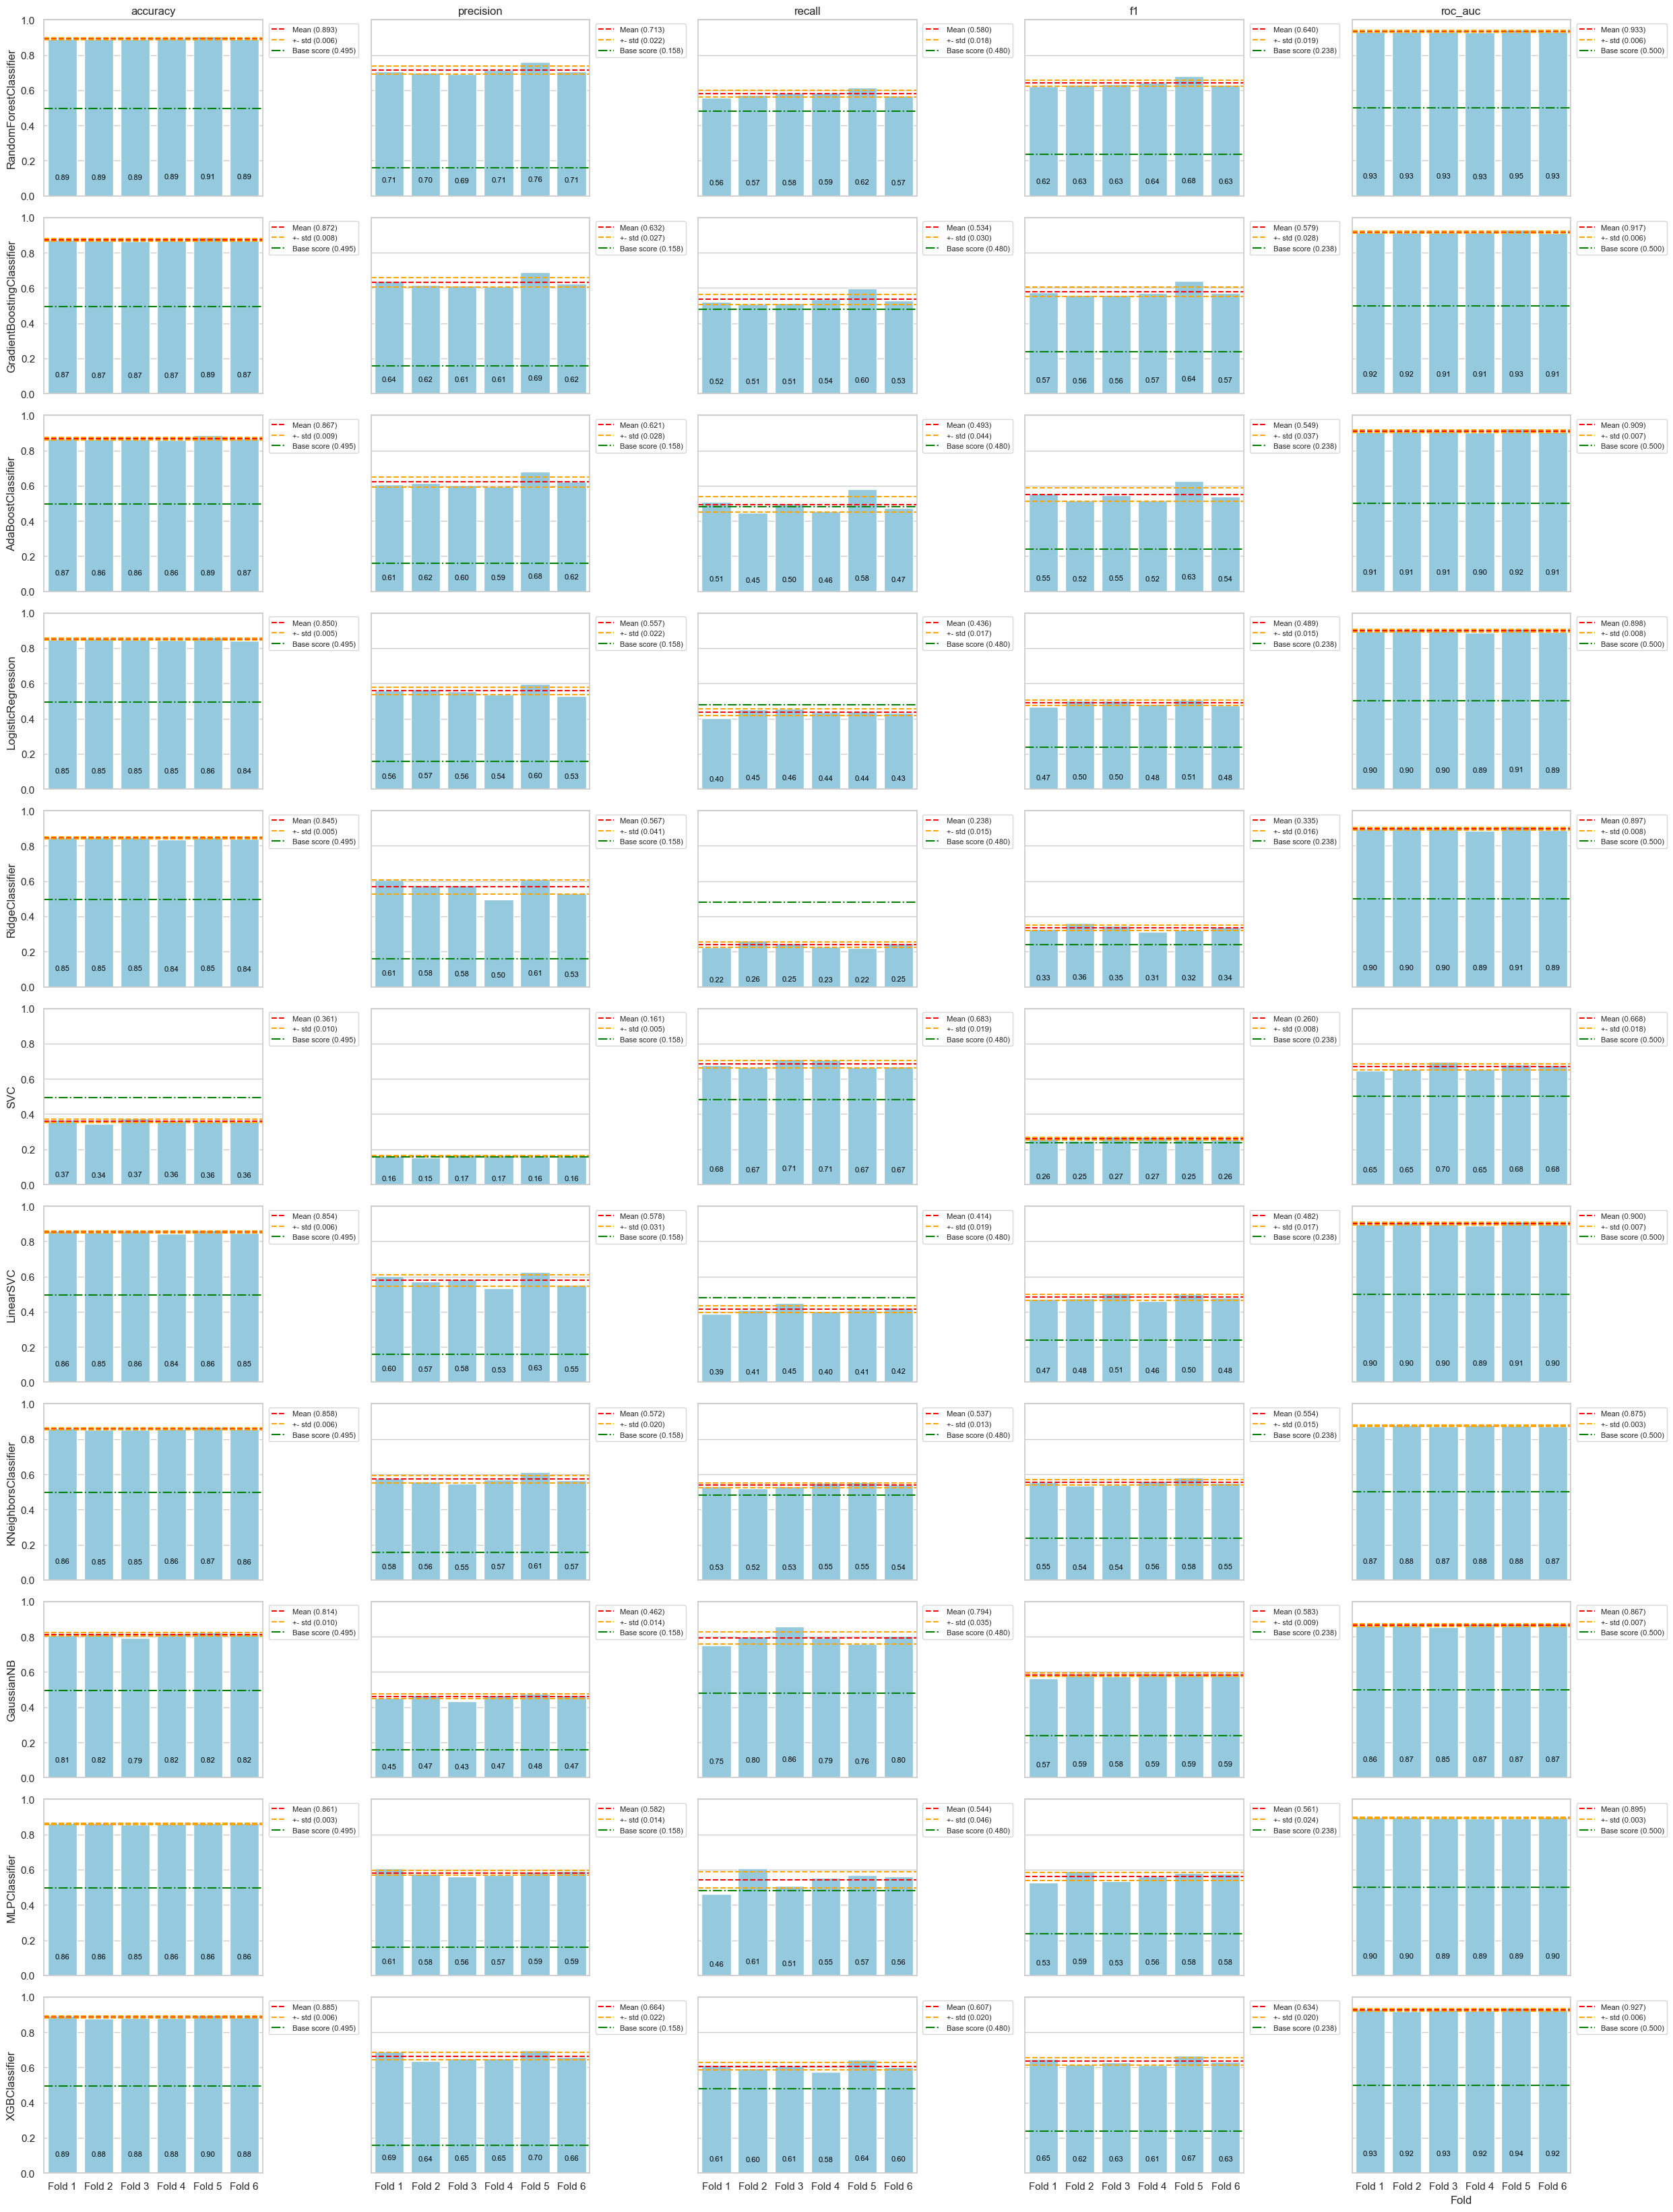

In [80]:
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(algorithm='SAMME'),
    LogisticRegression(max_iter=1000, dual=False),
    RidgeClassifier(),
    SVC(max_iter=1000),
    LinearSVC(dual=False, max_iter=1000),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(max_iter=1000),
    XGBClassifier()
]

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

scores = my_cross_validate(models, X_train, y_train, scoring=scoring)

<Figure size 1200x800 with 0 Axes>

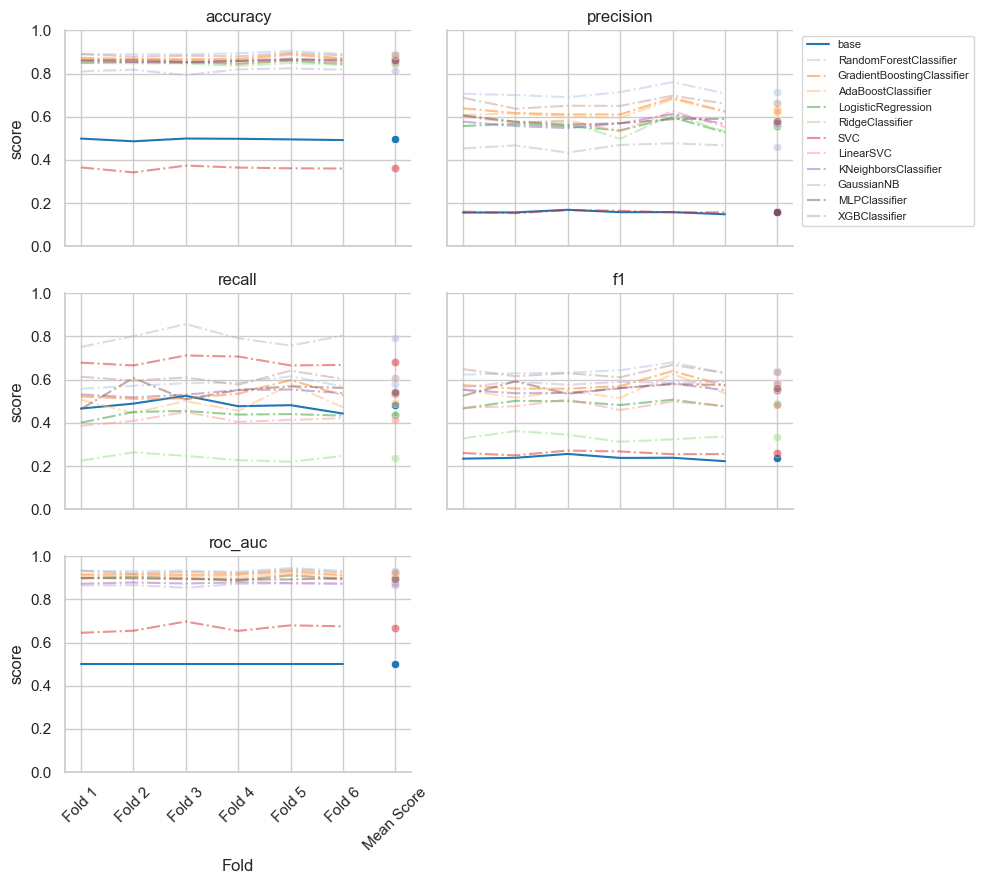

In [81]:
plot_scoring(scoring, scores)

In [82]:
print_scores(scores, "recall")

Models recall
	GaussianNB                    0.7938857111664775
	SVC                           0.6829383599833121
	XGBClassifier                 0.6066934921024825
	RandomForestClassifier        0.5804850803008504
	MLPClassifier                 0.5437999321566013
	KNeighborsClassifier          0.5373158188191348
	GradientBoostingClassifier    0.5344948591079762
	AdaBoostClassifier            0.49333848007392583
	LogisticRegression            0.4364806431866122
	LinearSVC                     0.41429117294997914
	RidgeClassifier               0.23840813652899137


In [83]:
print_scores(scores, "f1")

Models f1
	RandomForestClassifier        0.6399840164149802
	XGBClassifier                 0.6340540027889251
	GaussianNB                    0.5831107786032614
	GradientBoostingClassifier    0.5789501084486545
	MLPClassifier                 0.5611709666052485
	KNeighborsClassifier          0.5539355850935707
	AdaBoostClassifier            0.5492881373776033
	LogisticRegression            0.4891127483409263
	LinearSVC                     0.48191654627497477
	RidgeClassifier               0.3348761905954387
	SVC                           0.25996034517417105


In [84]:
print_scores(scores, "roc_auc")

Models roc_auc
	RandomForestClassifier        0.9333215754294653
	XGBClassifier                 0.9271466976381806
	GradientBoostingClassifier    0.9167357106489223
	AdaBoostClassifier            0.9088979595380599
	LinearSVC                     0.8995225497778612
	LogisticRegression            0.8981464206464741
	RidgeClassifier               0.89739705341036
	MLPClassifier                 0.8952207776711391
	KNeighborsClassifier          0.8749405763990152
	GaussianNB                    0.8670563180878653
	SVC                           0.6676875872468301


Science we predict whether client will be granted with a credit, we're more interested with high recall not high precision - after all, we'd prefer to guess that more people will be granted one than to discourage them from trying to.

Therefore further we'll proceed with GaussianNB (highest recall) and XGB Classifier (it can be greatly fine-tuned) and SVC (second highest recall).

In [85]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'eta': trial.suggest_loguniform('eta', 0.01, 0.5),
            'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
            'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        }
        return after_params_objective(params, X_train, y_train, model_class)
    return objective

study = optimize(X_train, y_train, XGBClassifier, create_objective, 1)

[I 2024-05-06 20:12:20,147] A new study created in memory with name: no-name-9a4739c3-b0a2-44f5-82f0-fdcd16b072d0
[I 2024-05-06 20:13:11,293] Trial 0 finished with value: 0.8864678668652617 and parameters: {'booster': 'dart', 'lambda': 0.09250021106345004, 'alpha': 0.0186367853786347, 'max_depth': 20, 'eta': 0.21765217795636518, 'gamma': 0.06052407712512823, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8864678668652617.


In [86]:
xgb_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, XGBClassifier)

Number of finished trials: 1
Best trial:
  Value: 0.8864678668652617
  Params: 
    booster: dart
    lambda: 0.09250021106345004
    alpha: 0.0186367853786347
    max_depth: 20
    eta: 0.21765217795636518
    gamma: 0.06052407712512823
    grow_policy: depthwise
Refitted best model f1-score on valid: 0.8939721792890263


In [87]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        params = {
            "var_smoothing": trial.suggest_loguniform('var_smoothing', 1e-10, 10.0)
        }
        return after_params_objective(params, X_train, y_train, model_class)
    return objective

study = optimize(X_train, y_train, GaussianNB, create_objective, 1)

[I 2024-05-06 20:13:24,269] A new study created in memory with name: no-name-77f0eae3-14fd-490a-8b96-863de103697a
[I 2024-05-06 20:13:24,466] Trial 0 finished with value: 0.8268524290969556 and parameters: {'var_smoothing': 0.00018382511308631208}. Best is trial 0 with value: 0.8268524290969556.


In [88]:
gaussian_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, GaussianNB)

Number of finished trials: 1
Best trial:
  Value: 0.8268524290969556
  Params: 
    var_smoothing: 0.00018382511308631208
Refitted best model f1-score on valid: 0.8234930448222566


In [89]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        C = trial.suggest_loguniform('C', 1e-5, 1e5)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        max_iter = trial.suggest_categorical("max_iter", [100])
        probability = trial.suggest_categorical("probability", [True])
        
        if kernel == 'poly':
            degree = trial.suggest_int('degree', 2, 5)
        else:
            degree = 3 
        
        if kernel in ['rbf', 'poly', 'sigmoid']:
            gamma = trial.suggest_loguniform('gamma', 1e-5, 1e5)
        else:
            gamma = 'scale'
        
        params = {
            "C": C,
            "kernel": kernel,
            "degree": degree,
            "gamma": gamma,
            "max_iter": max_iter,
            "probability": probability
        }
        return after_params_objective(params, X_train, y_train, model_class)
    return objective

study = optimize(X_train, y_train, SVC, create_objective, 1)

[I 2024-05-06 20:13:24,554] A new study created in memory with name: no-name-eec1f2db-9f2a-49da-a391-4f383f7cbf95
[I 2024-05-06 20:13:25,220] Trial 0 finished with value: 0.43435989286395865 and parameters: {'C': 2.2454339035237734, 'kernel': 'poly', 'max_iter': 100, 'probability': True, 'degree': 3, 'gamma': 0.00201712562031441}. Best is trial 0 with value: 0.43435989286395865.


In [90]:
svc_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, SVC)

Number of finished trials: 1
Best trial:
  Value: 0.43435989286395865
  Params: 
    C: 2.2454339035237734
    kernel: poly
    max_iter: 100
    probability: True
    degree: 3
    gamma: 0.00201712562031441
Refitted best model f1-score on valid: 0.8435857805255024


Lets try voting classifier

In [91]:
ensemble_clf = VotingClassifier(estimators=[('XGBClassifier', xgb_classifier), ('GaussianNB', gaussian_classifier), ('SVC', svc_classifier)], voting='soft')

ensemble_clf.fit(X_train, y_train)
y_pred = ensemble_clf.predict(X_val)
score = f1_score(y_val, y_pred, average="micro")

print(f"Refitted best model f1-score on valid: {score}")

Refitted best model f1-score on valid: 0.8890262751159196


## Deep Learning

In [92]:
def get_simple_model(dropout=0.2):
    return tf.keras.Sequential(
        [
            layers.Dense(256, input_shape=(X_train.shape[1],)),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(dropout),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(64),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(dropout),
            layers.Dense(1, activation="sigmoid"),
        ]
    )

In [93]:
import numpy as np

def get_simple_model(dropout=0.2):
    model = tf.keras.Sequential([
        layers.Dense(256, input_shape=(X_train.shape[1],)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(dropout),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(64),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# Compute class weights manually
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# Create the model
simple_model = get_simple_model()
simple_model.summary()
# Compile the model
simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'F1Score'])

# Train the model with class weights
history = simple_model.fit(X_train, y_train, epochs=13, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)               │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8478 - F1Score: 0.2808 - Precision: 0.4159 - Recall: 0.8341 - accuracy: 0.7822 - loss: 0.9783 - val_AUC: 0.8870 - val_F1Score: 0.2682 - val_Precision: 0.4054 - val_Recall: 0.9621 - val_accuracy: 0.7756 - val_loss: 0.4389
Epoch 2/13
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8904 - F1Score: 0.2853 - Precision: 0.4463 - Recall: 0.9407 - accuracy: 0.7958 - loss: 0.7656 - val_AUC: 0.8904 - val_F1Score: 0.2682 - val_Precision: 0.4397 - val_Recall: 0.9242 - val_accuracy: 0.8059 - val_loss: 0.3484
Epoch 3/13
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8981 - F1Score: 0.2814 - Precision: 0.4419 - Recall: 0.9347 - accuracy: 0.7960 - loss: 0.7395 - val_AUC: 0.8942 - val_F1Score: 0.2682 - val_Precision: 0.4150 - val_Recall: 0.9501 - val_accuracy: 0.7849 - val_loss: 0.3765
Epoch 4/13
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9005 - F1Score: 0.2828 - Precision: 0.4380 - Recall: 0.9474 - accuracy: 0.7911 - loss: 0.7185

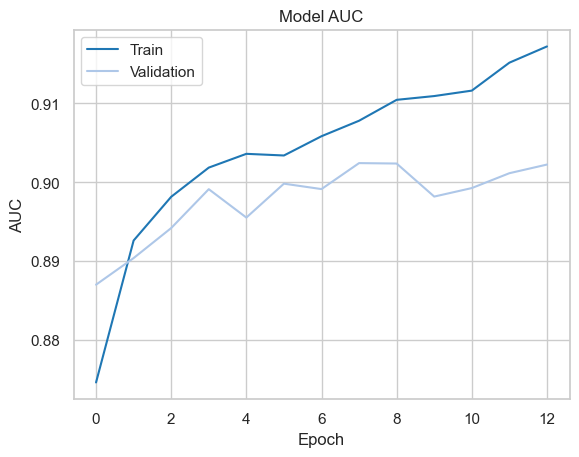

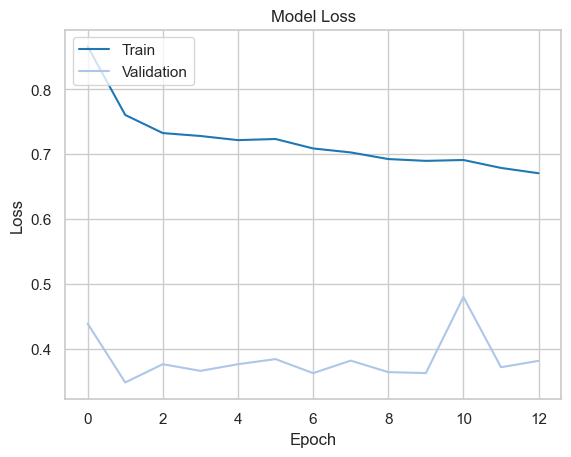

In [94]:
# Plot accuracy
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [95]:
preds = simple_model.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)


# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      2734
           1       0.43      0.94      0.59       501

    accuracy                           0.80      3235
   macro avg       0.71      0.85      0.73      3235
weighted avg       0.90      0.80      0.82      3235

ROC AUC score: 0.9022532842143073


In [96]:
simple_classifier_02 = get_simple_model()
simple_classifier_02.summary()
history = train_model(simple_classifier_02, X_train, y_train, X_val, y_val)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_116 (Dense)               │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.2879 - loss: 0.3529 - val_f1_score: 0.2682 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2801 - loss: 0.2780 - val_f1_score: 0.2682 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2717 - loss: 0.2670 - val_f1_score: 0.2682 - val_loss: 0.2647 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2856 - loss: 0.2738 - val_f1_score: 0.2682 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2848 - loss: 0.2655 - val_f1_score: 0.2682 - val_loss: 0.2721 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2812 - loss: 0.2607 - val_f1_score: 0.2682 - val_loss: 0.2750 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2872 - loss: 0.

In [97]:
preds = simple_classifier_02.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)


# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2734
           1       0.59      0.45      0.51       501

    accuracy                           0.87      3235
   macro avg       0.75      0.70      0.72      3235
weighted avg       0.86      0.87      0.86      3235

ROC AUC score: 0.9065840520860253


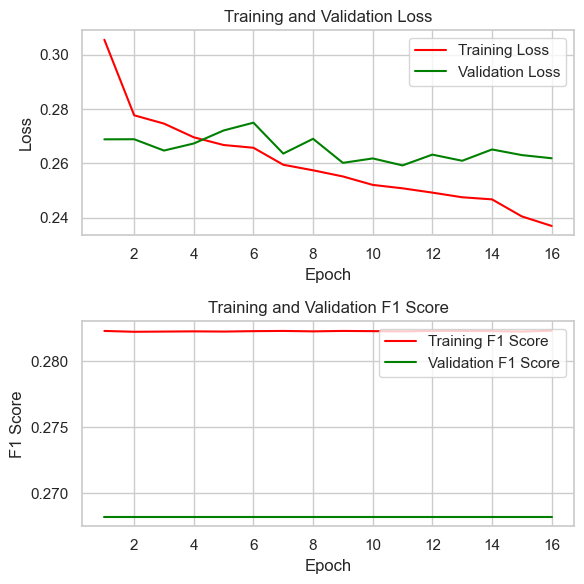

In [98]:
plot_history(history)

In [99]:
simple_classifier_00 = get_simple_model()
simple_classifier_00.summary()
history = train_model(simple_classifier_00, X_train, y_train, X_val, y_val)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_121 (Dense)               │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.2842 - loss: 0.3655 - val_f1_score: 0.2682 - val_loss: 0.2763 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2874 - loss: 0.2826 - val_f1_score: 0.2682 - val_loss: 0.2650 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2777 - loss: 0.2699 - val_f1_score: 0.2682 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2751 - loss: 0.2595 - val_f1_score: 0.2682 - val_loss: 0.2621 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2774 - loss: 0.2668 - val_f1_score: 0.2682 - val_loss: 0.2688 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2862 - loss: 0.2735 - val_f1_score: 0.2682 - val_loss: 0.2729 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2833 - loss: 0.

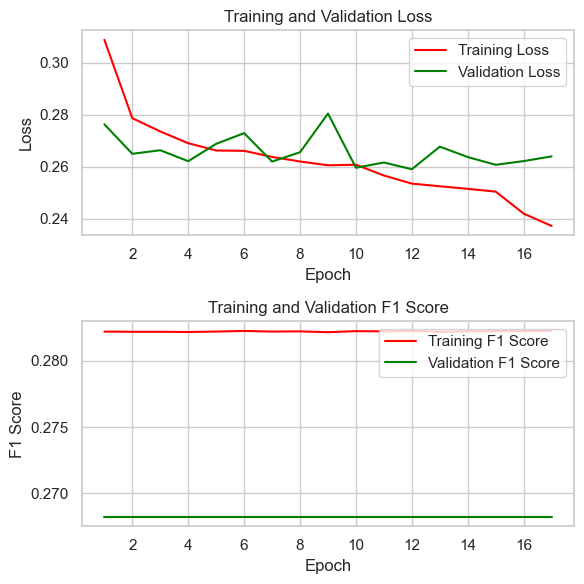

In [100]:
plot_history(history)

In [101]:
import numpy as np

def residual_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    residual = x
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Add()([x, residual])
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' activation for binary classification
    model = tf.keras.Model(inputs, outputs)
    return model

# Compute class weights manually
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# Create and compile the model
residual_net_classifier = residual_net()
residual_net_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'F1Score'])

# Train the model with class weights
history = residual_net_classifier.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)


Epoch 1/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8149 - F1Score: 0.2814 - Precision: 0.3538 - Recall: 0.8192 - accuracy: 0.7198 - loss: 1.1340 - val_AUC: 0.8854 - val_F1Score: 0.2682 - val_Precision: 0.4188 - val_Recall: 0.9521 - val_accuracy: 0.7879 - val_loss: 0.4291
Epoch 2/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8775 - F1Score: 0.2832 - Precision: 0.4355 - Recall: 0.9001 - accuracy: 0.7910 - loss: 0.8369 - val_AUC: 0.8952 - val_F1Score: 0.2682 - val_Precision: 0.4303 - val_Recall: 0.9421 - val_accuracy: 0.7978 - val_loss: 0.3887
Epoch 3/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8841 - F1Score: 0.2931 - Precision: 0.4569 - Recall: 0.9063 - accuracy: 0.7989 - loss: 0.8213 - val_AUC: 0.8942 - val_F1Score: 0.2682 - val_Precision: 0.4236 - val_Recall: 0.9461 - val_accuracy: 0.7923 - val_loss: 0.3862
Epoch 4/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8845 - F1Score: 0.2819 - Precision: 0.4374 - Recall: 0.9199 - accuracy: 0.7928 - loss: 0.7745

In [102]:
def residual_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    residual = x
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Add()([x, residual])
    outputs = layers.Dense(1, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [103]:
residual_net_classifier = get_simple_model()
residual_net_classifier.summary()
history = train_model(residual_net_classifier, X_train, y_train, X_val, y_val)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_130 (Dense)               │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.2753 - loss: 0.3520 - val_f1_score: 0.2682 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2794 - loss: 0.2702 - val_f1_score: 0.2682 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2701 - loss: 0.2662 - val_f1_score: 0.2682 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2877 - loss: 0.2758 - val_f1_score: 0.2682 - val_loss: 0.2628 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2794 - loss: 0.2681 - val_f1_score: 0.2682 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2823 - loss: 0.2620 - val_f1_score: 0.2682 - val_loss: 0.2614 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2783 - loss: 0.

In [104]:
import numpy as np

class DropConnect(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(DropConnect, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

def drop_connect_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = DropConnect(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = DropConnect(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = DropConnect(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' activation for binary classification
    model = tf.keras.Model(inputs, outputs)
    return model

# Compute class weights manually
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# Create and compile the model
drop_connect_net_classifier = drop_connect_net()
drop_connect_net_classifier.summary()
drop_connect_net_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'F1Score'])

# Train the model with class weights
history = drop_connect_net_classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)


Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect_18 (DropConnect)   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect_19 (DropConnect)   │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect_20 (DropConnect)   │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,409 (68.00 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8090 - F1Score: 0.2798 - Precision: 0.3751 - Recall: 0.7327 - accuracy: 0.7593 - loss: 1.1281 - val_AUC: 0.8898 - val_F1Score: 0.2682 - val_Precision: 0.4279 - val_Recall: 0.9421 - val_accuracy: 0.7960 - val_loss: 0.3795
Epoch 2/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8758 - F1Score: 0.2830 - Precision: 0.4367 - Recall: 0.9115 - accuracy: 0.7917 - loss: 0.8438 - val_AUC: 0.8911 - val_F1Score: 0.2682 - val_Precision: 0.4073 - val_Recall: 0.9601 - val_accuracy: 0.7774 - val_loss: 0.3929
Epoch 3/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8897 - F1Score: 0.2847 - Precision: 0.4309 - Recall: 0.9439 - accuracy: 0.7836 - loss: 0.7774 - val_AUC: 0.8934 - val_F1Score: 0.2682 - val_Precision: 0.4154 - val_Recall: 0.9501 - val_accuracy: 0.7852 - val_loss: 0.4084
Epoch 4/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8968 - F1Score: 0.2858 - Precision: 0.4513 - Recall: 0.9422 - accuracy: 0.7994 - loss: 0.7482

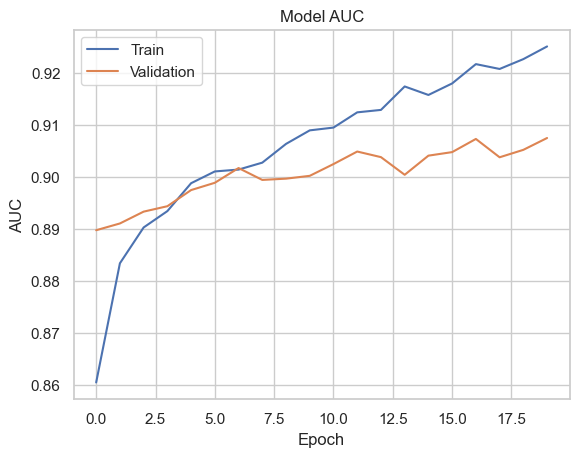

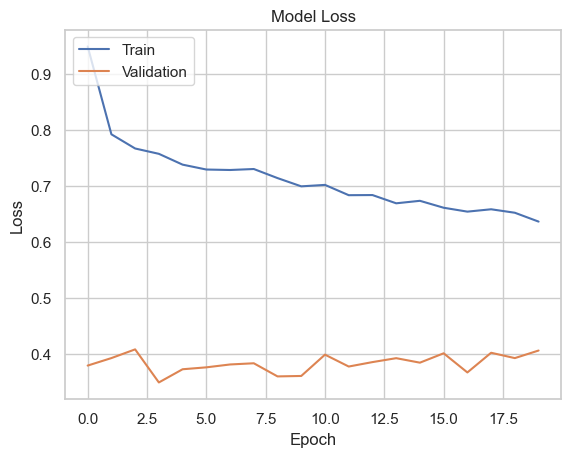

In [105]:
# Plot accuracy
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [106]:
preds = drop_connect_net_classifier.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)


# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      2734
           1       0.44      0.91      0.59       501

    accuracy                           0.81      3235
   macro avg       0.71      0.85      0.73      3235
weighted avg       0.90      0.81      0.83      3235

ROC AUC score: 0.9079047464690224


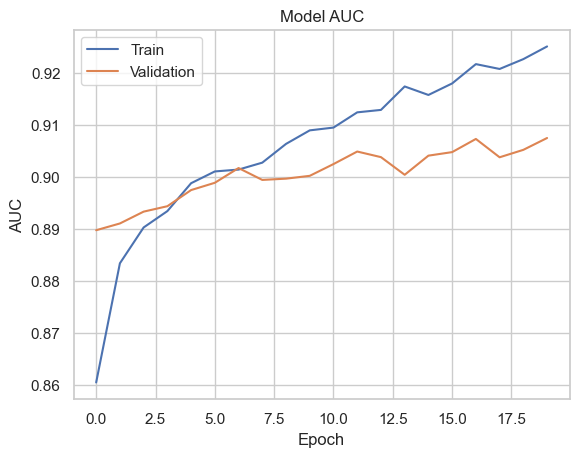

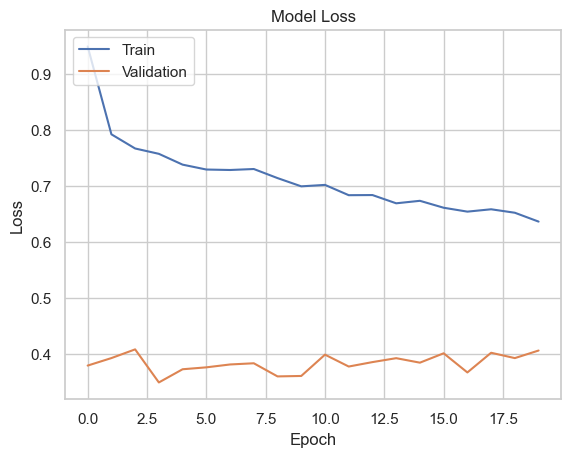

In [107]:
# Plot accuracy
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [108]:
import numpy as np

# Compute class weights manually
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# Rest of the code remains the same
def dense_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

dense_net_classifier = dense_net()
dense_net_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'F1Score'])

# Train the model with class weights
history = dense_net_classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)


Epoch 1/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7864 - F1Score: 0.2778 - Precision: 0.3202 - Recall: 0.7860 - accuracy: 0.6908 - loss: 1.1838 - val_AUC: 0.8919 - val_F1Score: 0.2682 - val_Precision: 0.4389 - val_Recall: 0.9182 - val_accuracy: 0.8056 - val_loss: 0.3896
Epoch 2/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8805 - F1Score: 0.2860 - Precision: 0.4450 - Recall: 0.9006 - accuracy: 0.7958 - loss: 0.8342 - val_AUC: 0.8924 - val_F1Score: 0.2682 - val_Precision: 0.4164 - val_Recall: 0.9441 - val_accuracy: 0.7864 - val_loss: 0.4276
Epoch 3/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8814 - F1Score: 0.2834 - Precision: 0.4317 - Recall: 0.9064 - accuracy: 0.7875 - loss: 0.8047 - val_AUC: 0.8942 - val_F1Score: 0.2682 - val_Precision: 0.4185 - val_Recall: 0.9481 - val_accuracy: 0.7879 - val_loss: 0.4057
Epoch 4/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8878 - F1Score: 0.2783 - Precision: 0.4351 - Recall: 0.9256 - accuracy: 0.7936 - loss: 0.7702

In [109]:
from sklearn.metrics import classification_report, roc_auc_score
# Make predictions
preds = dense_net_classifier.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)

# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      2734
           1       0.43      0.96      0.59       501

    accuracy                           0.80      3235
   macro avg       0.71      0.86      0.73      3235
weighted avg       0.90      0.80      0.82      3235

ROC AUC score: 0.9021671361008778


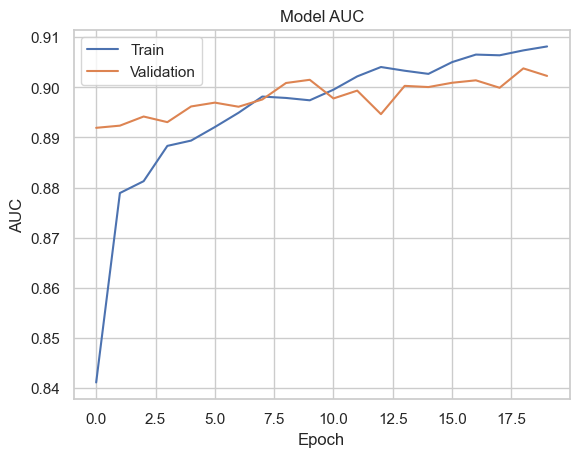

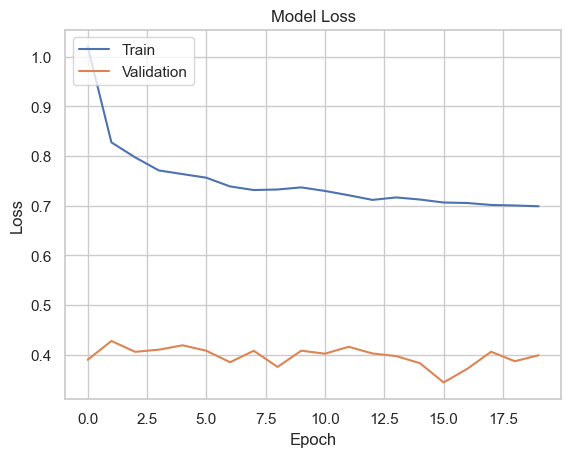

In [110]:
# Plot accuracy
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Final model

Based on above research we'll go into production with our voting classifier. We believe it'll have best generalization capabilities and it will focus more on recall to precision.

In [111]:
from sklearn.base import BaseEstimator, TransformerMixin

class FinalModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pipeline = pipeline
        self.model = ensemble_clf
    
    def predict(self, X):
        if "FINALIZED_LOAN" not in X.columns:
            X["FINALIZED_LOAN"] = np.ones(X.shape[0])
        
        X = pipeline.transform(X)
        X.drop(columns=["FINALIZED_LOAN"], inplace=True)
        return ensemble_clf.predict(X.values)    

    def set_output(self, *args, **kwargs):
        return self


In [112]:
df_val = pd.read_csv("../data/orig_valid.csv")
y_val = df_val["FINALIZED_LOAN"]
df_val.drop(columns=["FINALIZED_LOAN"], inplace=True)

final_model = FinalModel()
y_pred = final_model.predict(df_val)

In [113]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2734
           1       0.64      0.64      0.64       501

    accuracy                           0.89      3235
   macro avg       0.78      0.79      0.79      3235
weighted avg       0.89      0.89      0.89      3235



In [114]:
joblib.dump(
    final_model, "../pipelines/final_model.joblib"
)

['../pipelines/final_model.joblib']